In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/jacquelineburos/miniconda3/envs/python3/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
/home/jacquelineburos/.local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
INFO:stancache.seed:Setting seed to 1245502385


## Simulate survival data 

In order to demonstrate the use of this model, we will first simulate some survival data using `survivalstan.sim.sim_data_exp_correlated`. As the name implies, this function simulates data assuming a constant hazard throughout the follow-up time period, which is consistent with the Exponential survival function.

This function includes two simulated covariates by default (`age` and `sex`). We also simulate a situation where hazard is a function of the simulated value for `sex`. 

We also center the `age` variable since this will make it easier to interpret estimates of the baseline hazard.


In [4]:
d = stancache.cached(
    survivalstan.sim.sim_data_exp_correlated,
    N=100,
    censor_time=20,
    rate_form='1 + sex',
    rate_coefs=[-3, 0.5],
)
d['age_centered'] = d['age'] - d['age'].mean()

INFO:stancache.stancache:sim_data_exp_correlated: cache_filename set to sim_data_exp_correlated.cached.N_100.censor_time_20.rate_coefs_54462717316.rate_form_1 + sex.pkl
INFO:stancache.stancache:sim_data_exp_correlated: Loading result from cache


*Aside: In order to make this a more reproducible example, this code is using a file-caching function `stancache.cached` to wrap a function call to `survivalstan.sim.sim_data_exp_correlated`. *

## Explore simulated data

Here is what these data look like - this is `per-subject` or `time-to-event` form:

In [5]:
d.head()

,age,sex,rate,true_t,t,event,index,age_centered
0,59,male,0.082085,20.948771,20.000000,False,0,4.18
1,58,male,0.082085,12.827519,12.827519,True,1,3.18
2,61,female,0.049787,27.018886,20.000000,False,2,6.18
3,57,female,0.049787,62.220296,20.000000,False,3,2.18
4,55,male,0.082085,10.462045,10.462045,True,4,0.18


*It's not that obvious from the field names, but in this example "subjects" are indexed by the field `index`.*

We can plot these data using `lifelines`, or the rudimentary plotting functions provided by `survivalstan`.

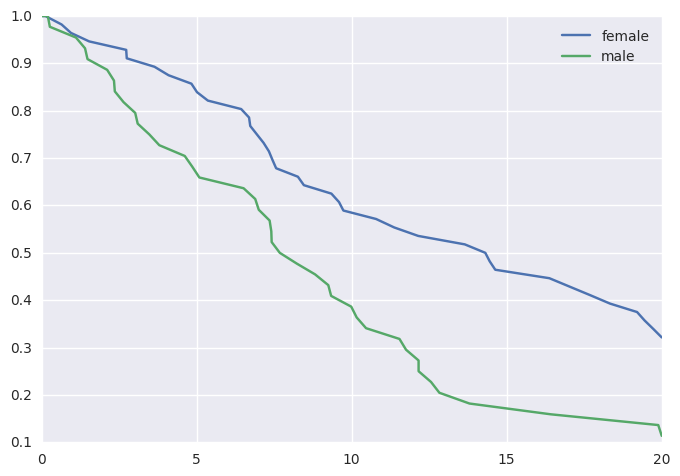

In [6]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

## model1: original spec

In [7]:
model_code = '''
functions {
  // Defines the log survival
  vector log_S (vector t, real shape, vector rate) {
    vector[num_elements(t)] log_S;
    for (i in 1:num_elements(t)) {
      log_S[i] = gamma_lccdf(t[i]|shape,rate[i]); 
    }
    return log_S;
  }
  
  // Defines the log hazard
  vector log_h (vector t, real shape, vector rate) {
    vector[num_elements(t)] log_h;
    vector[num_elements(t)] ls;
    ls = log_S(t,shape,rate);
    for (i in 1:num_elements(t)) {
      log_h[i] = gamma_lpdf(t[i]|shape,rate[i]) - ls[i];
    }
    return log_h;
  }
  
  // Defines the sampling distribution
  real surv_gamma_lpdf (vector t, vector d, real shape, vector rate) {
    vector[num_elements(t)] log_lik;
    real prob;
    log_lik = d .* log_h(t,shape,rate) + log_S(t,shape,rate);
    prob = sum(log_lik);
    return prob;
  }
}

data {
  int N;                            // number of observations
  vector<lower=0>[N] y;             // observed times
  vector<lower=0,upper=1>[N] event;     // censoring indicator (1=observed, 0=censored)
  int M;                            // number of covariates
  matrix[N, M] x;                    // matrix of covariates (with n rows and H columns)
}

parameters {
  vector[M] beta;         // Coefficients in the linear predictor (including intercept)
  real<lower=0> alpha;    // shape parameter
}

transformed parameters {
  vector[N] linpred;
  vector[N] mu;
  linpred = x*beta;
  for (i in 1:N) {
    mu[i] = exp(linpred[i]);
  }
}

model {
  alpha ~ gamma(0.01,0.01);
  beta ~ normal(0,5);
  y ~ surv_gamma(event, alpha, mu);
}
'''

Now, we are ready to fit our model using `survivalstan.fit_stan_survival_model`. 

We pass a few parameters to the fit function, many of which are required. See ?survivalstan.fit_stan_survival_model for details. 

Similar to what we did above, we are asking `survivalstan` to cache this model fit object. See [stancache](http://github.com/jburos/stancache) for more details on how this works. Also, if you didn't want to use the cache, you could omit the parameter `FIT_FUN` and `survivalstan` would use the standard pystan functionality.


In [8]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'model 1',
    model_code = model_code,
    df = d,
    time_col = 't',
    event_col = 'event',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    drop_intercept = False,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_14429915565770599621.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_14429915565770599621.pystan_2_12_0_0.stanfit.chains_4.data_25476010973.iter_5000.seed_9001.pkl
INFO:stancache.stancache:sampling: Loading result from cache


In [9]:
# 0:00:40.518775 elapsed

In [10]:
survivalstan.utils.print_stan_summary([testfit], pars=['lp__', 'alpha', 'beta'])

               mean   se_mean        sd        2.5%         50%       97.5%      Rhat
lp__    -278.113380  0.021718  1.358348 -281.579969 -277.815032 -276.424942  1.000465
alpha      1.220129  0.002561  0.170488    0.913076    1.209632    1.581949  1.000245
beta[0]   -2.703902  0.003699  0.226779   -3.173168   -2.695839   -2.275841  1.000271
beta[1]    0.608266  0.002897  0.199169    0.221442    0.606373    1.003776  1.000226
beta[2]    0.006018  0.000183  0.014844   -0.023068    0.005959    0.035536  1.000075


## model2: alternate version of surv_gamma_lpdf

In [11]:
model_code2 = '''
functions {
  // Defines the log survival
  real surv_gamma_lpdf (vector t, vector d, real shape, vector rate) {
    vector[num_elements(t)] log_lik;
    real prob;
    for (i in 1:num_elements(t)) {
      log_lik[i] = d[i] * (gamma_lpdf(t[i]|shape,rate[i]) - gamma_lccdf(t[i]|shape,rate[i]))
                      + gamma_lccdf(t[i]|shape,rate[i]);
    }
    prob = sum(log_lik);
    return prob;
  }
}
data {
  int N;                            // number of observations
  vector<lower=0>[N] y;             // observed times
  vector<lower=0,upper=1>[N] event;     // censoring indicator (1=observed, 0=censored)
  int M;                            // number of covariates
  matrix[N, M] x;                    // matrix of covariates (with n rows and H columns)
}
parameters {
  vector[M] beta;         // Coefficients in the linear predictor (including intercept)
  real<lower=0> alpha;    // shape parameter
}
transformed parameters {
  vector<lower=0>[N] mu;
  {
      vector[N] linpred;
      linpred = x*beta;
      mu = exp(linpred);
  }
}

model {
  alpha ~ gamma(0.01,0.01);
  beta ~ normal(0,5);
  y ~ surv_gamma(event, alpha, mu);
}
'''

In [12]:
testfit2 = survivalstan.fit_stan_survival_model(
    model_cohort = 'model 2',
    model_code = model_code2,
    df = d,
    time_col = 't',
    event_col = 'event',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    drop_intercept = False,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_9177012762674257483.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_9177012762674257483.pystan_2_12_0_0.stanfit.chains_4.data_25476010973.iter_5000.seed_9001.pkl
INFO:stancache.stancache:sampling: Loading result from cache


In [13]:
# 0:00:21.081723 elapsed

In [14]:
survivalstan.utils.print_stan_summary([testfit2], pars=['lp__', 'alpha', 'beta'])

               mean   se_mean        sd        2.5%         50%       97.5%      Rhat
lp__    -278.122019  0.022342  1.367441 -281.523430 -277.808097 -276.440635  1.001051
alpha      1.218976  0.002590  0.171529    0.906313    1.208893    1.586105  1.000714
beta[0]   -2.704073  0.003788  0.228848   -3.187193   -2.693108   -2.287256  1.000886
beta[1]    0.604867  0.002814  0.201056    0.208092    0.605508    0.993031  1.000143
beta[2]    0.006629  0.000188  0.014733   -0.021872    0.006506    0.036200  1.000063


## model3: use `log_mix` inside surv_gamma_lpdf

In [15]:
model_code3 = '''
functions {
  // Defines the log survival
  real surv_gamma_lpdf (vector t, vector d, real shape, vector rate) {
    vector[num_elements(t)] log_lik;
    real prob;
    for (i in 1:num_elements(t)) {
      log_lik[i] = log_mix(d[i], gamma_lpdf(t[i]|shape,rate[i]), gamma_lccdf(t[i]|shape,rate[i]));
    }
    prob = sum(log_lik);
    return prob;
  }
}
data {
  int N;                            // number of observations
  vector<lower=0>[N] y;             // observed times
  vector<lower=0,upper=1>[N] event; // censoring indicator (1=observed, 0=censored)
  int M;                            // number of covariates
  matrix[N, M] x;                   // matrix of covariates (with n rows and H columns)
}
parameters {
  vector[M] beta;         // Coefficients in the linear predictor (including intercept)
  real<lower=0> alpha;    // shape parameter
}
transformed parameters {
  vector[N] linpred;
  vector[N] mu;
  linpred = x*beta;
  mu = exp(linpred);
}

model {
  alpha ~ gamma(0.01,0.01);
  beta ~ normal(0,5);
  y ~ surv_gamma(event, alpha, mu);
}
'''

In [16]:
testfit3 = survivalstan.fit_stan_survival_model(
    model_cohort = 'model 3',
    model_code = model_code3,
    df = d,
    time_col = 't',
    event_col = 'event',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    drop_intercept = False,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_1293841621968646714.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_1293841621968646714.pystan_2_12_0_0.stanfit.chains_4.data_25476010973.iter_5000.seed_9001.pkl
INFO:stancache.stancache:sampling: Loading result from cache


In [17]:
#0:00:20.284146 elapsed

In [18]:
survivalstan.utils.print_stan_summary([testfit3], pars=['lp__', 'alpha', 'beta'])

               mean   se_mean        sd        2.5%         50%       97.5%      Rhat
lp__    -278.092768  0.021055  1.344719 -281.491359 -277.783232 -276.425885  1.000812
alpha      1.216429  0.002640  0.166944    0.905732    1.207800    1.576275  1.000432
beta[0]   -2.708385  0.003770  0.220966   -3.173480   -2.697460   -2.307317  1.000622
beta[1]    0.609834  0.002799  0.199563    0.223234    0.609396    1.008451  1.000295
beta[2]    0.006028  0.000180  0.014812   -0.022443    0.006036    0.036197  1.000265


## model4: vectorize surv_gamma_lpdf

In [40]:
model_code4 = '''
functions {
    int count_value(vector a, real val) {
        int s;
        s = 0;
        for (i in 1:num_elements(a)) 
            if (a[i] == val) 
                s = s + 1;
        return s;
    }

  // Defines the log survival
  real surv_gamma_lpdf (vector t, vector d, real shape, vector rate, int num_cens, int num_obs) {
    vector[2] log_lik;
    int idx_obs[num_obs];
    int idx_cens[num_cens];
    real prob;
    int i_cens;
    int i_obs;
    i_cens = 1;
    i_obs = 1;
    for (i in 1:num_elements(t)) {
        if (d[i] == 1) {
            idx_obs[i_obs] = i;
            i_obs = i_obs+1;
        }
        else {
            idx_cens[i_cens] = i;
            i_cens = i_cens+1;
        }
    }
    print(idx_obs);
    log_lik[1] = gamma_lpdf(t[idx_obs] | shape, rate[idx_obs]);
    log_lik[2] = gamma_lccdf(t[idx_cens] | shape, rate[idx_cens]);
    prob = sum(log_lik);
    return prob;
  }
}
data {
  int N;                            // number of observations
  vector<lower=0>[N] y;             // observed times
  vector<lower=0,upper=1>[N] event; // censoring indicator (1=observed, 0=censored)
  int M;                            // number of covariates
  matrix[N, M] x;                   // matrix of covariates (with n rows and H columns)
}
transformed data {
  int num_cens;
  int num_obs;
  num_obs = count_value(event, 1);
  num_cens = N - num_obs;
}
parameters {
  vector[M] beta;         // Coefficients in the linear predictor (including intercept)
  real<lower=0> alpha;    // shape parameter
}
transformed parameters {
  vector[N] linpred;
  vector[N] mu;
  linpred = x*beta;
  mu = exp(linpred);
}
model {
  alpha ~ gamma(0.01,0.01);
  beta ~ normal(0,5);
  y ~ surv_gamma(event, alpha, mu, num_cens, num_obs);
}
'''

In [41]:
testfit4 = survivalstan.fit_stan_survival_model(
    model_cohort = 'model 4',
    model_code = model_code4,
    df = d,
    time_col = 't',
    event_col = 'event',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    drop_intercept = False,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_16881928540873162731.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Starting execution
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b18a6495e568fcff90662e16a3d2aa85 NOW.
INFO:stancache.stancache:StanModel: Execution completed (0:01:09.439292 elapsed)
INFO:stancache.stancache:StanModel: Saving results to cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_16881928540873162731.pystan_2_12_0_0.stanfit.chains_4.data_25476010973.iter_5000.seed_9001.pkl
INFO:stancache.stancache:sampling: Starting execution
INFO:stancache.stancache:sampling: Execution completed (0:00:06.245552 elapsed)
INFO:stancache.stancache:sampling: Saving results to cache
/home/jacquelineburos

In [42]:
# 0:00:06.245552 elapsed

In [43]:
survivalstan.utils.print_stan_summary([testfit4], pars=['lp__', 'alpha', 'beta'])

               mean   se_mean        sd        2.5%         50%       97.5%      Rhat
lp__    -278.097416  0.020380  1.353386 -281.543138 -277.782205 -276.445123  0.999867
alpha      1.216149  0.002525  0.169578    0.913312    1.206908    1.574024  1.000702
beta[0]   -2.708518  0.003627  0.228658   -3.188661   -2.700493   -2.278788  1.000723
beta[1]    0.610593  0.002824  0.201974    0.224438    0.607700    1.030164  1.000744
beta[2]    0.006211  0.000171  0.014493   -0.022229    0.006113    0.035095  1.000222


## compare coefficient estimates for each model spec

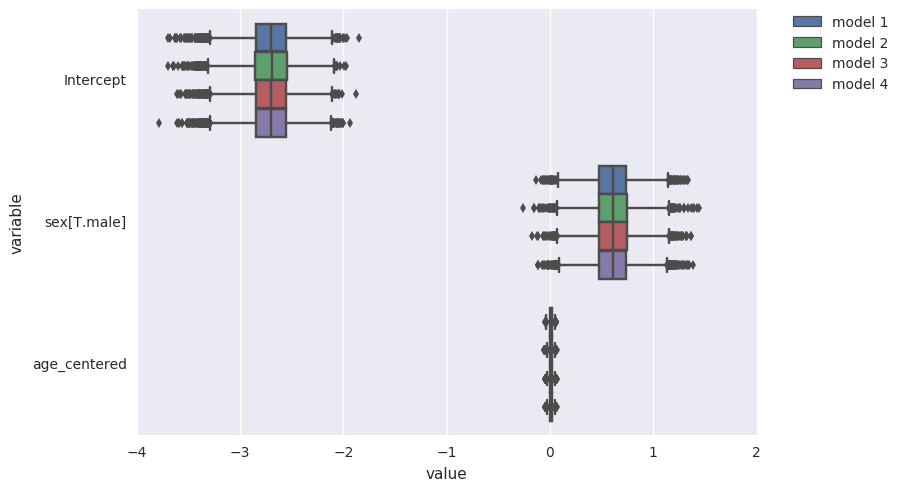

In [44]:
survivalstan.utils.plot_coefs([testfit, testfit2, testfit3, testfit4])